# Request Type
Command vs Question, Personal vs. impersonal

## Helpers

In [1]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
import seaborn as sns
from helpers.occurences import count_occurrences
import pandas as pd
import sqlite3
from helpers.statistical_tests import compare_genders


def count(df, group_name, word_types, word_lists):
    for word_type, word_list in zip(word_types, word_lists):
        for word in word_list:
            df[word] = df['conversational'].apply(lambda x: (count_occurrences(x, word, True))/len(x.split()))
        df[word_type] = df[word_list].sum(axis=1)
    df[group_name] = df[word_types].sum(axis=1)
    return df

gender_palette = {'Woman (cisgender)': 'red', 'Man (cisgender)': 'blue'}
age_palette = {'19-25': 'red', '26-30': 'orange', '31-35': 'yellow', '36-40': 'green', '41-50': 'blue', '51-60': 'purple'}


def box_plot(df, id_vars, bar_variables, x_tick_labels, x_label, y_label, hue_variable, palette):
    melted = df.melt(
    id_vars=id_vars,
    value_vars=bar_variables,
    var_name=x_label,
    value_name=y_label
)

    plt.figure(figsize=(8,6))
    sns.boxplot(
        data=melted,
        x=x_label,
        y=y_label,
        hue=hue_variable,
        palette=palette,
        width=0.7
    )

    plt.title(f'Request Type by {hue_variable}')
    plt.ylabel('Average Proportion of Prompts')
    plt.xlabel('Prompting Behavior')
    plt.legend(title=hue_variable)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.xticks(
        ticks=range(len(x_tick_labels)),
        labels=x_tick_labels,
        rotation=45
    )


    plt.show()


from helpers.statistical_tests_new import compare_groups
from statsmodels.stats.multitest import multipletests


def groupwise_comparison_with_correction(df, columns, one_sided=False, direction="greater"):
    stat_vals = []
    dfs = []
    p_vals = []
    test_types = []
    directions = []
    one_sideds = []
    female_means = []
    male_means = []
    female_stds = []
    male_stds = []
    n_females = []
    n_males = []
    nonzero_females = []
    nonzero_males = []
    effsizes = []
    effsize_types = []
    cis = []
    for col in columns:
        result = compare_groups(df, col, group_column="gender", group_x="Man (cisgender)", group_y="Woman (cisgender)",
                                one_sided=one_sided, direction=direction)
        stat_vals.append(result['test_statistic'])
        dfs.append(result['df'])
        p_vals.append(result['p_value'])
        test_types.append(result['test_type'])
        directions.append(result['direction'])
        one_sideds.append(result['one_sided'])
        female_means.append(result['mean_y'])
        male_means.append(result['mean_x'])
        female_stds.append(result['std_y'])
        male_stds.append(result['std_x'])
        n_females.append(result['n_y'])
        n_males.append(result['n_x'])
        nonzero_females.append(result['hits_y'])
        nonzero_males.append(result['hits_x']),
        effsizes.append(result['effect_size']),
        effsize_types.append(result['effect_size_type'])
        cis.append(result['effect_size_CI'])
    reject, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    results = pd.DataFrame({
        'word': columns,
        'test type': test_types,
        'direction': directions,
        'one_sided': one_sideds,
        'df': dfs,
        'stat_value': stat_vals,
        'p_value': p_vals,
        'corrected p_value': pvals_corrected,
        'mean_f': female_means,
        'mean_m': male_means,
        'std_f': female_stds,
        'std_m': male_stds,
        'n_f': n_females,
        'n_m': n_males,
        'n_hits_f': nonzero_females,
        'n_hits_m': nonzero_males,
        'effsize': effsizes,
        'effsize_type': effsize_types,
        'ci': cis,
    })
    return results


def compute_anova(df, id_vars, value_vars, x_label, y_label):
    melted = df.melt(
    id_vars=id_vars,
    value_vars=value_vars,
    var_name=x_label,
    value_name=y_label
    )

    model = ols(f'{y_label} ~ gender * {x_label}', data=melted).fit()
    return sm.stats.anova_lm(model, typ=2)


## Reimport

In [2]:
db_path = "../../data/giicg.db"
conn = sqlite3.connect(db_path)
prompts = pd.read_sql("SELECT * FROM categorized_prompts", conn)
prompts

,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,age,...,we_question,boosters,greetings,anger,joy,neutral,please,thanks,surprise,scepticism
0,1,1,user,"parsing data from python iterator, how it coul...","parsing data from python iterator, how it coul...",,0,Man (cisgender),6,19-25,...,0,0,0,0,0,1,0,0,0,0
1,730,32,user,Write python function to do operations with in...,Write python function to do operations with in...,,0,Man (cisgender),6,19-25,...,0,0,0,0,0,1,0,0,0,0
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,Write shortest tutorial on creating RAG on ema...,,0,Man (cisgender),6,19-25,...,0,0,0,0,0,1,0,0,0,0
3,1135,55,user,what is FAISS,what is FAISS,,1,Man (cisgender),6,19-25,...,0,0,0,0,0,1,0,0,0,0
4,1137,55,user,Transform given code to process large .mbox file,Transform given code to process large .mbox file,,0,Man (cisgender),6,19-25,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code. I want to: Get nodes and edge...,"def run_query(query, n_results):\n query_em...",0,Man (cisgender),92,36-40,...,0,0,0,0,0,1,0,0,0,0
754,1845,37,user,\n nun möchte ich judgement balancing m...,nun möchte ich judgement balancing mi...,,0,Woman (cisgender),29,26-30,...,0,0,0,0,0,1,0,0,0,0
755,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,ich sehe keine veränderung im Plot. Was i...,,0,Woman (cisgender),29,26-30,...,0,0,0,0,0,1,0,0,0,0
756,1849,2,user,\n I am working on the problem of reconstru...,I am working on the problem of reconstruc...,,1,Man (cisgender),8,19-25,...,0,0,0,0,0,1,0,0,0,0


## Manual annotation
interaction markers:
simple_dialog_markers: yes, no, okay, yeah, nope, nah ✅
Boosters: super, nice, great, good, amazing, perfect, totally ✅
greetings: hi, hey ✅
Politeness: please, thanks ✅
guidance: almost (at the beginning), better (at the beginning)
humor: lol, scherzo

Emotion:
surprise: ✅
scepticism: ✅
negative: ✅
positive: ✅
neutral: ✅


Question types:
you_question: can you, could you ✅
i_question: can i, do i, kann ich, faccio, mache ich, cant i, what are my, what is my, for me, i am, i do, i dont, should i, i also want ✅
We_question: can we, could we, können wir, shouldnt we ✅
unpersonal_question: how to, what is

Command Types
you_command: write a function, do xyz ✅
I_want_statement: i want, i need, i have to, i think, i have ✅
We_command: let's, we should, we need ✅
we_statement : we need, we should, we have to, wir müssen ✅
unpersonal_command: it should be like xyz

## Count Prompt Types per user

In [3]:
other_columns = [
           'yes_no_okay',
           'greetings',
           'please',
           'thanks',
           'boosters',
           'joy',
           'neutral',
           'surprise',
           'scepticism',
           ]
request_columns = ['unpersonal_question', 'i_question', 'can_you_question', 'we_question', 'unpersonal_command', 'i_statement', 'you_command', 'we_command']

columns = other_columns + request_columns

user_means = (
    prompts.groupby(['user_id'])[columns].mean()
)
user_info_cols = ['gender','age', 'work_exp_years']
user_means = user_means.merge(
    prompts[['user_id'] + user_info_cols].drop_duplicates(),
    left_index=True, right_on='user_id'
)

user_means = user_means[user_means['gender'].isin(['Man (cisgender)', 'Woman (cisgender)'])]

user_means

,yes_no_okay,greetings,please,thanks,boosters,joy,neutral,surprise,scepticism,unpersonal_question,...,can_you_question,we_question,unpersonal_command,i_statement,you_command,we_command,user_id,gender,age,work_exp_years
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.555556,...,0.000000,0.111111,0.000000,0.111111,0.444444,0.000000,6,Man (cisgender),19-25,3.0
756,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,8,Man (cisgender),19-25,1.0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.090909,...,0.727273,0.000000,0.000000,0.181818,0.000000,0.000000,11,Woman (cisgender),26-30,1.0
20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.666667,...,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,15,Man (cisgender),26-30,6.0
23,0.200000,0.000000,0.160000,0.000000,0.040000,0.040000,0.960000,0.000000,0.000000,0.040000,...,0.160000,0.000000,0.160000,0.480000,0.080000,0.000000,16,Woman (cisgender),19-25,None
48,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.750000,...,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,25,Man (cisgender),26-30,6.0
52,0.227273,0.045455,0.181818,0.181818,0.090909,0.090909,0.727273,0.045455,0.000000,0.090909,...,0.363636,0.045455,0.090909,0.500000,0.045455,0.045455,28,Woman (cisgender),31-35,5.0
754,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000,29,Woman (cisgender),26-30,None
75,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.400000,...,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,31,Man (cisgender),36-40,22.0
80,0.000000,0.000000,0.075758,0.000000,0.015152,0.015152,0.924242,0.000000,0.121212,0.090909,...,0.075758,0.000000,0.287879,0.045455,0.363636,0.030303,34,Man (cisgender),51-60,20.0


## Plot

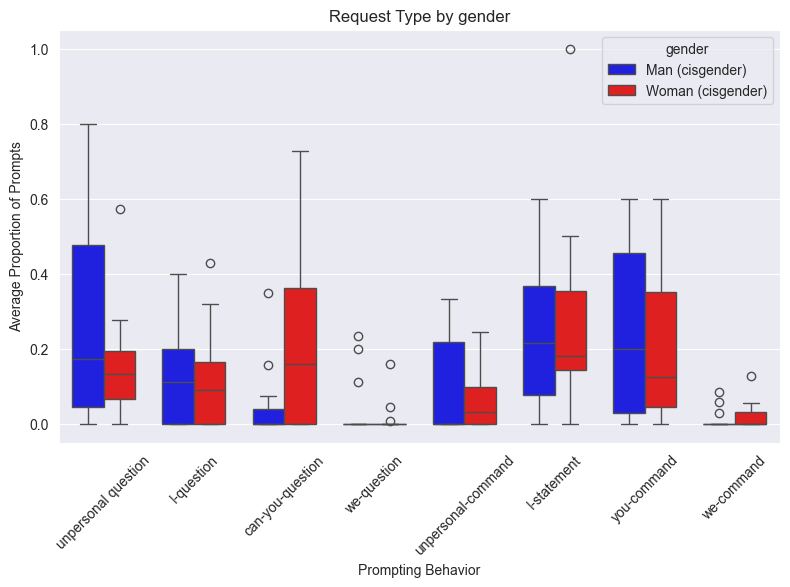

In [4]:
request_column_x_labels = [
    "unpersonal question",
    "I-question",
    "can-you-question",
    "we-question",
    "unpersonal-command",
    "I-statement",
    "you-command",
    "we-command",
]

box_plot(user_means, ['user_id', 'gender'], request_columns, request_column_x_labels, 'Prompt Type', 'Normalized Rate (per number of prompts)', 'gender', gender_palette)

In [5]:
from helpers.make_latex_table import create_latex_tables

rq_types_overall_results = groupwise_comparison_with_correction(user_means, request_columns).sort_values(by="p_value", ascending=True)
create_latex_tables(rq_types_overall_results, "latex/request_types_stats.tex", "latex/request_types_means_hits.tex")

rq_types_overall_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
2,can_you_question,Mann-Whitney U,greater,False,None,49.000000,0.018120,0.144960,0.160000,0.000000,0.230680,0.095715,13.0,15.0,9,5,-0.497436,RBC,"[-0.84, -0.1]"
0,unpersonal_question,Mann-Whitney U,greater,False,None,114.500000,0.444452,0.962378,0.132479,0.172840,0.150329,0.285802,13.0,15.0,11,11,0.174359,RBC,"[-0.24, 0.61]"
6,you_command,Mann-Whitney U,greater,False,None,105.500000,0.727277,0.962378,0.125000,0.200000,0.214719,0.215160,13.0,15.0,10,11,0.082051,RBC,"[-0.38, 0.48]"
3,we_question,Fisher's exact,greater,False,None,0.833333,0.744928,0.962378,NaN,NaN,NaN,NaN,NaN,NaN,3,3,0.833333,Odds ratio,None
4,unpersonal_command,Mann-Whitney U,greater,False,None,104.500000,0.752304,0.962378,0.032258,0.000000,0.076668,0.128813,13.0,15.0,8,7,0.071795,RBC,"[-0.37, 0.47]"
7,we_command,Fisher's exact,greater,False,None,0.400000,0.933333,0.962378,NaN,NaN,NaN,NaN,NaN,NaN,5,3,0.400000,Odds ratio,None
5,i_statement,Mann-Whitney U,greater,False,None,95.500000,0.944806,0.962378,0.181818,0.215686,0.259102,0.186729,13.0,15.0,12,12,-0.020513,RBC,"[-0.42, 0.43]"
1,i_question,Mann-Whitney U,greater,False,None,99.000000,0.962378,0.962378,0.089744,0.111111,0.136125,0.130542,13.0,15.0,9,9,0.015385,RBC,"[-0.42, 0.47]"


## Directness & Indirectness

"Directness": [
        "unpersonal_command", "unpersonal_question",
        "you_command", "i_statement", "we_command"
    ],
"Indirectness": ["can_you_question", "we_question", "i_question"]

In [19]:
user_means['direct'] = user_means[[
        "unpersonal_command",
        "you_command",  "we_command", "unpersonal_question",
    ]].mean(axis=1)
user_means['indirect'] = user_means[["can_you_question", "we_question", "i_question", "i_statement" ]].sum(axis=1)

directness_means = user_means.groupby(['gender'])[['direct', 'indirect']].mean().reset_index()

directness_means


,gender,direct,indirect
0,Man (cisgender),0.159961,0.437859
1,Woman (cisgender),0.114637,0.639775


In [20]:
results = groupwise_comparison_with_correction(user_means, ['direct', 'indirect'])
create_latex_tables(results, "latex/direct_indirect_stats.tex", "latex/direct_indirect_means_hits.tex")
results


,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,direct,T-test,two-sided,False,25.999922,2.050029,0.050572,0.050572,0.114637,0.159961,0.054206,0.062783,13,15,13,15,0.768467,Cohen's d,"[0.05, 1.6]"
1,indirect,T-test,two-sided,False,22.377997,-2.160922,0.041662,0.050572,0.639775,0.437859,0.274134,0.210364,13,15,13,14,-0.834725,Cohen's d,"[-1.74, -0.12]"


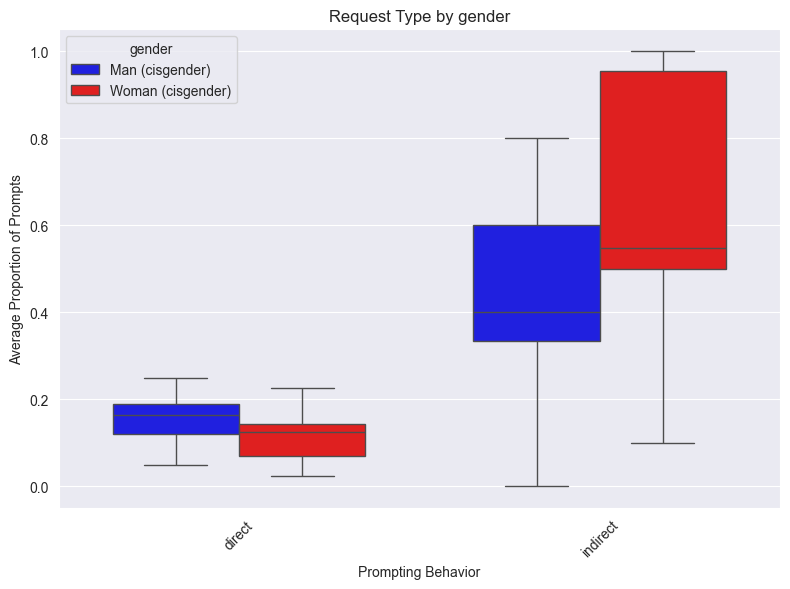

In [21]:
column_x_labels = [
    "direct",
    "indirect"
]

box_plot(user_means, ['user_id', 'gender'], ['direct', 'indirect'], column_x_labels, 'Prompt Type', 'Normalized Rate (per number of prompts)', 'gender', gender_palette)
# box_plot(
#     user_means,
#     id_vars=['user_id', 'gender'],                   # these are not used for y axis
#     bar_variables=['directness', 'indirectness'],
#     column_x_labels,# plot both categories
#     x_label='Category',
#     y_label='Mean Score',
#     hue_variable='gender',
#     palette=gender_palette
# )


## Question vs statement/command

In [9]:
user_means['statement'] = user_means[[
        "unpersonal_command",
        "you_command",  "we_command", "i_statement"
    ]].mean(axis=1)
user_means['question'] = user_means[["can_you_question", "we_question", "i_question",  "unpersonal_question" ]].sum(axis=1)

# Now, compute average for each user
question_statement_means = user_means.groupby(['gender'])[['question', 'statement']].mean().reset_index()

question_statement_means

,gender,question,statement
0,Man (cisgender),0.478222,0.149870
1,Woman (cisgender),0.511006,0.146829


In [10]:
results = groupwise_comparison_with_correction(user_means, ['question', 'statement'])
create_latex_tables(results, "latex/question_statement_stats.tex", "latex/question_statement_means_hits.tex")
results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,question,T-test,two-sided,False,25.490362,-0.317181,0.753690,0.923942,0.511006,0.478222,0.271830,0.273850,13,15,12,13,-0.120124,Cohen's d,"[-0.9, 0.63]"
1,statement,T-test,two-sided,False,22.947172,0.096524,0.923942,0.923942,0.146829,0.149870,0.091119,0.072872,13,15,13,15,0.037178,Cohen's d,"[-0.72, 0.91]"


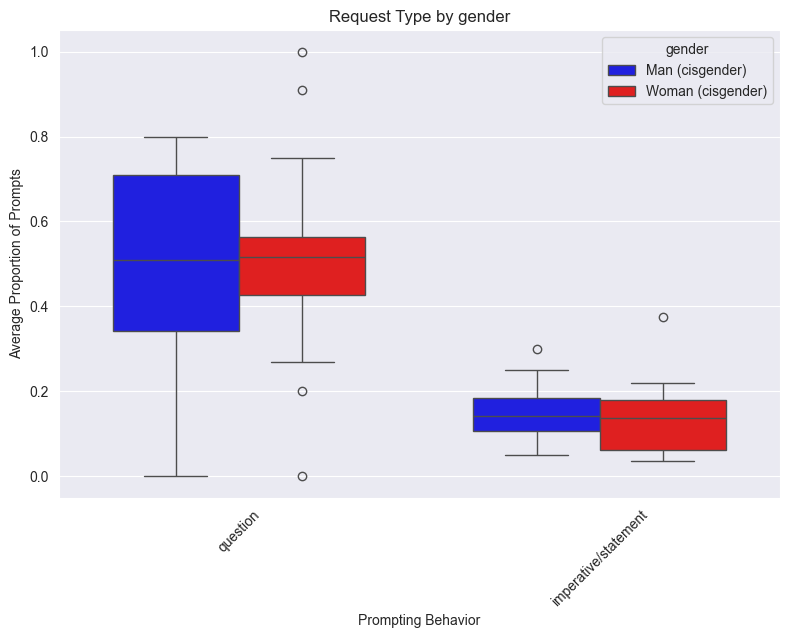

In [15]:
column_x_labels = [
    "question",
    "imperative/statement"
]

box_plot(user_means, ['user_id', 'gender'], ["question",
    "statement"], column_x_labels, 'Prompt Type', 'Normalized Rate (per number of prompts)', 'gender', gender_palette)

## Personal vs unpersonal

In [12]:
## Question vs statement/command
user_means['impersonal'] = user_means[[
    "unpersonal_command","unpersonal_question"]].mean(axis=1)
user_means['personal'] = user_means[["can_you_question", "we_question", "i_question",  "you_command", "we_command", "i_statement"]].sum(
    axis=1)

# Now, compute average for each user
question_statement_means = user_means.groupby(['gender'])[['impersonal', 'personal']].mean().reset_index()

question_statement_means

,gender,impersonal,personal
0,Man (cisgender),0.190955,0.695792
1,Woman (cisgender),0.110640,0.877042


In [13]:
results = groupwise_comparison_with_correction(user_means, ['impersonal', 'personal'])
create_latex_tables(results, "latex/impersonal_personal_stats.tex", "latex/impersonal_personal__eff.tex")
results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,impersonal,T-test,two-sided,False,20.360553,1.742912,0.096433,0.098734,0.110640,0.190955,0.074150,0.159712,13,15,11,13,0.629606,Cohen's d,"[-0.11, 1.23]"
1,personal,T-test,two-sided,False,25.842677,-1.712748,0.098734,0.098734,0.877042,0.695792,0.248052,0.311424,13,15,13,14,-0.638342,Cohen's d,"[-1.34, 0.04]"


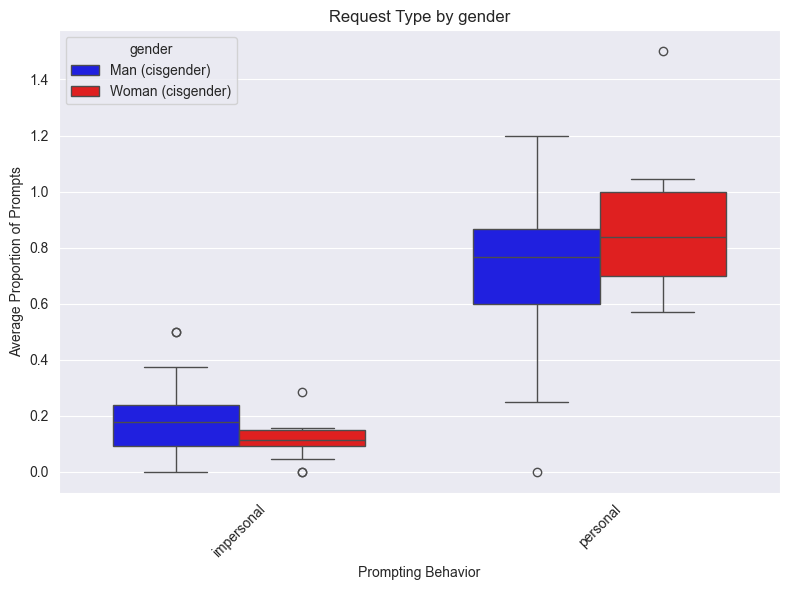

In [14]:
column_x_labels = ["impersonal", "personal"]

box_plot(user_means, ['user_id', 'gender'], ["impersonal", "personal"], column_x_labels, 'Prompt Type',
         'Normalized Rate (per number of prompts)', 'gender', gender_palette)

## All in one

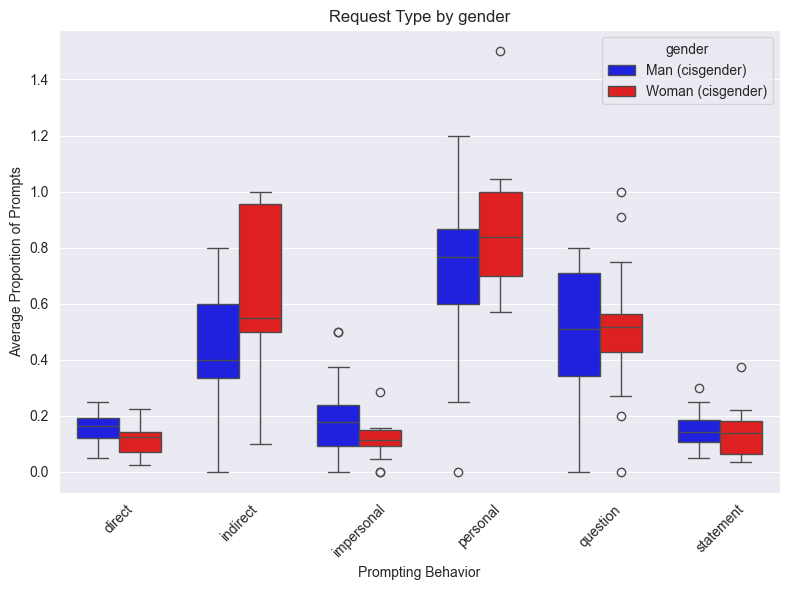

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,direct,T-test,two-sided,False,25.999922,2.050029,0.050572,0.148101,0.114637,0.159961,0.054206,0.062783,13,15,13,15,0.768467,Cohen's d,"[-0.01, 1.56]"
1,indirect,T-test,two-sided,False,22.377997,-2.160922,0.041662,0.148101,0.639775,0.437859,0.274134,0.210364,13,15,13,14,-0.834725,Cohen's d,"[-1.6, -0.05]"
2,impersonal,T-test,two-sided,False,20.360553,1.742912,0.096433,0.148101,0.110640,0.190955,0.074150,0.159712,13,15,11,13,0.629606,Cohen's d,"[-0.02, 1.27]"
3,personal,T-test,two-sided,False,25.842677,-1.712748,0.098734,0.148101,0.877042,0.695792,0.248052,0.311424,13,15,13,14,-0.638342,Cohen's d,"[-1.23, 0.14]"
4,question,T-test,two-sided,False,25.490362,-0.317181,0.753690,0.904428,0.511006,0.478222,0.271830,0.273850,13,15,12,13,-0.120124,Cohen's d,"[-0.85, 0.65]"
5,statement,T-test,two-sided,False,22.947172,0.096524,0.923942,0.923942,0.146829,0.149870,0.091119,0.072872,13,15,13,15,0.037178,Cohen's d,"[-0.73, 0.91]"


In [25]:
all_results = groupwise_comparison_with_correction(user_means, ['direct', 'indirect', 'impersonal', 'personal', 'question', 'statement'])
create_latex_tables(all_results, "latex/request_types_all_stats.tex", "latex/request_types_all_eff.tex")

column_x_labels = ['direct', 'indirect', 'impersonal', 'personal', 'question', 'statement']

box_plot(user_means, ['user_id', 'gender'], ['direct', 'indirect', 'impersonal', 'personal', 'question', 'statement'], column_x_labels, 'Prompt Type',
         'Normalized Rate (per number of prompts)', 'gender', gender_palette)

all_results